EuroSAT

In [ ]:
# Library imports
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [ ]:
# Let's build your first CNN model

class nnModel(nn.Module):
  def __init__(self, number_of_classes=10):
    super(nnModel, self).__init__() # NN Module Initialization
    # 1st Convolutional layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv1_bn=nn.BatchNorm2d(32)
    #self.dropout1 = nn.Dropout(p=0.25)
    # 2nd Convolutional layer
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2_bn=nn.BatchNorm2d(64)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    # 3nd Convolutional layer
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv3_bn=nn.BatchNorm2d(128)
    #self.dropout3 = nn.Dropout(p=0.25)
    # 4th Convolutional layer
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv4_bn=nn.BatchNorm2d(256)
    self.maxpool4 = nn.MaxPool2d(kernel_size=4)
    #self.dropout4 = nn.Dropout(p=0.25)
    # 5th Convolutional layer
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv5_bn=nn.BatchNorm2d(512)

# ---------Conected Layers-------------
    # 1st Fully Connected layer (Linear layer)
    self.fc1 = nn.Linear(in_features=512*8*8, out_features=2048)
    self.fc1_bn=nn.BatchNorm1d(2048)
    # 2nd Fully Connected layer (Linear layer)
    self.fc2 = nn.Linear(in_features=2048, out_features=128) # Last layer's output must be the same as the number of classes/categories 
    self.fc2_bn=nn.BatchNorm1d(128)    
    # Dropout
    self.dropout = nn.Dropout(p=0.25)
    # 3th Fully Connected layer (Linear layer)
    self.fc3 = nn.Linear(in_features = 128, out_features = number_of_classes)

  def forward(self, x):
    # In "forward" function, you define the behaviour of your CNN
    # Activation functions are also implemented in "forward" function

    # 1st Convolutional layer
    x = self.conv1(x)
    x = F.relu(self.conv1_bn(x))
    #x = self.dropout1(x)
    # 2nd Convolutional layer
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = F.relu(self.conv2_bn(x))
    # 3th conv layer
    x = self.conv3(x)
    x = F.relu(self.conv3_bn(x))
    #x = self.dropout3(x)
    # 4th conv layer
    x = self.conv4(x)
    x = self.maxpool4(x)
    x = F.relu(self.conv4_bn(x))
    #x = self.dropout4(x)
    #5th conv layer
    x = self.conv5(x)
    x = F.relu(self.conv5_bn(x))

    # Before passing features to the linear layers, you need to "flatten" the features.
    flat_x = x.view(x.shape[0], -1)

    # 1st Fully Connected layer (Linear layer)
    flat_x = self.fc1(flat_x)
    flat_x = F.relu(self.fc1_bn(flat_x))
    #flat_x = self.dropout(flat_x) # You can use dropout wherever you "want"
    # 2nd Fully Connected layer (Linear layer)
    flat_x = self.fc2(flat_x) # Usually, last layer does not need activation layer
    flat_x = F.relu(self.fc2_bn(flat_x))

    flat_x = self.dropout(flat_x)

    # 3th Fully Connected layer (Linear layer)
    flat_x = self.fc3(flat_x)

    flat_x = F.log_softmax(flat_x,dim=1)

    return flat_x

In [ ]:
# Check your built CNN model
cnn_model = nnModel(10)
print("CNN Architecture: "+ str(cnn_model))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('\nThe model will run on', device)
cnn_model = cnn_model.to(device)

# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 64, 64), batch_size = 5) 

In [ ]:
from torchvision . datasets import EuroSAT
import torchvision . transforms as tt
import numpy as np
import torchvision.transforms as transforms # Image Transforms
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 
from torchvision.transforms import ToTensor
from skimage.util import random_noise
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [ ]:
transform = tt.ToTensor ()
dataset = EuroSAT ( download = True , root = "dataset/" , transform = transform )
# define TrainingSIZE and TestingSIZE considering the desired split
TrainingSIZE = int ( len ( dataset ) *0.8)
TestingSIZE = int ( len ( dataset ) *0.2)
# ( e . g . , TrainingSIZE = int ( len ( dataset ) *0.5) ) .
training_data , testing_data = random_split ( dataset ,[ TrainingSIZE , TestingSIZE ])

# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

In [ ]:
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 32 # 16 images per batch

# Training Set
training_loader = DataLoader(dataset = training_data, \
                            batch_size = batch_size, \
                            sampler = training_sampler)

# Validation Set
valid_loader = DataLoader(dataset = training_data, \
                        batch_size = batch_size, \
                        sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = DataLoader(dataset = testing_data, \
                            batch_size = batch_size, \
                            shuffle = True)

In [ ]:
# Visualization of a whole batch
import matplotlib.pyplot as plt

# Get images
dataiter = iter(training_loader)
images, labels = dataiter.next() # Get the images and their labels

# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(16)
for idx in np.arange(batch_size):
    # Add a subplot for the image 
    ax = fig.add_subplot(4, int(batch_size/2), idx+1, xticks=[], yticks=[])
    # Subplot with the image 
    ax.imshow(np.transpose(images[idx], (1, 2, 0)), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

TRAINING

In [ ]:
# Library imports
import torch.optim as optim

[1,  1000] loss: 1.789
[1,  2000] loss: 1.484
(Validation Set) Epoch: 1 Loss: 0.041744690984487534 Acc: 53.28
[2,  1000] loss: 1.935
[2,  2000] loss: 1.161
(Validation Set) Epoch: 2 Loss: 0.034017773106694224 Acc: 62.43
[3,  1000] loss: 1.599
[3,  2000] loss: 1.014
(Validation Set) Epoch: 3 Loss: 0.03156312758177519 Acc: 64.56
[4,  1000] loss: 1.419
[4,  2000] loss: 0.915
(Validation Set) Epoch: 4 Loss: 0.02890637957006693 Acc: 68.455
[5,  1000] loss: 1.299
[5,  2000] loss: 0.839
(Validation Set) Epoch: 5 Loss: 0.02637054360061884 Acc: 70.995
[6,  1000] loss: 1.212
[6,  2000] loss: 0.786
(Validation Set) Epoch: 6 Loss: 0.025250932659208775 Acc: 72.155
[7,  1000] loss: 1.117
[7,  2000] loss: 0.733
(Validation Set) Epoch: 7 Loss: 0.02478817521631718 Acc: 72.725
[8,  1000] loss: 1.064
[8,  2000] loss: 0.690
(Validation Set) Epoch: 8 Loss: 0.023347157007455824 Acc: 74.495
[9,  1000] loss: 1.001
[9,  2000] loss: 0.666
(Validation Set) Epoch: 9 Loss: 0.023316018371284008 Acc: 74.515
Epoch 00

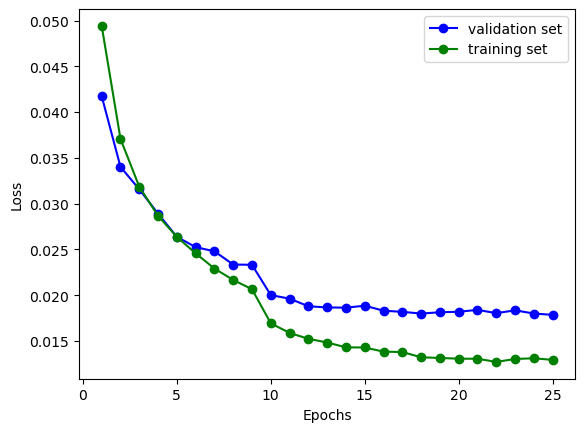

Training is completed!


In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = .01
num_epochs = 25

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
#optimizer = optim.SGD(cnn_model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 7, verbose=True)

# Training
running_loss = 0.0
training_loss = 0.0

x = list()
y_valid = list()
y_train = list()

# Early stopping
the_last_loss = 100
patience = 2
trigger_times = 0

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    training_loss += loss.item()
    running_loss += loss.item()
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0

  y_train.append(training_loss/len(training_idx))
  training_loss = 0

  
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  loss_values = []
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()

      loss_values.append(valid_total_loss)

  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))
  #plt.plot(np.array(loss_values)/len(valid_idx), 'r')
  # x e y para o plot da loss por epoch
  x.append(epoch+1)
  y_valid.append(valid_total_loss/len(valid_idx))
  

  # Early stopping
  the_current_loss = valid_total_loss/ len(valid_idx)
  if the_current_loss > the_last_loss:
    trigger_times += 1
    print('trigger times:', trigger_times)

    if trigger_times >= patience:
      print(x)
      print(y_train)
      print(y_valid)

      # plot  
      plt.plot(x, y_valid, 'bo-', label ='validation set')
      plt.plot(x, y_train, 'go-', label ='training set')

      plt.xlabel("Epochs")
      plt.ylabel("Loss")
        
      # Function add a legend  
      plt.legend()
        
      # function to show the plot
      plt.show()
      print('Early stopping!\nStart to test process.')
      break

    else:
      print('trigger times: 0')
      trigger_times = 0

    the_last_loss = the_current_loss
    print("Training is completed!")
  scheduler.step(training_loss/len(training_idx))

print(x)
print(y_train)
print(y_valid)

# plot  
plt.plot(x, y_valid, 'bo-', label ='validation set')
plt.plot(x, y_train, 'go-', label ='training set')

plt.xlabel("Epochs")
plt.ylabel("Loss")
  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

print("Training is completed!")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 10
correct = 0
total = 0
total_loss = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]
mean = 0

cnn_model.eval()

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    # -------------------------------------------------------
    # ----------------- Compute metrics here ----------------
    # -------------------------------------------------------

    total += labels.size(0)
    correct += (predicted == labels).sum().item()   
    c = (predicted == labels).squeeze()

    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix += metrics.confusion_matrix(predicted.cpu(),labels.cpu(), labels = [x for x in range(num_classes)])
    


# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))

# Performance per Class
for i in range(num_classes):

    if class_total[i] == 0:
      print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
    else:
      print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))

    mean += (class_correct[i] / class_total[i]) 

#print('Mean Accuracy: %2d %%' % (100*(mean/num_classes)))

# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix)
 
F1_mean = f1_score(labels.cpu(), predicted.cpu(), average='weighted', labels=np.unique(predicted.cpu()))
#print("Global F1 Score: " + str(F1_micro*100))
print("Media de F1 Score das classes: " + str(F1_mean*100))

Prec = precision_score(labels.cpu(), predicted.cpu(), average="weighted", labels=np.unique(predicted.cpu()))
Rec = recall_score(labels.cpu(), predicted.cpu(), average="weighted", labels=np.unique(predicted.cpu())) 
print("Precision: " + str(Prec*100))
print("Recall: " + str(Rec*100))